<a href="https://colab.research.google.com/github/nihilkottal/GIS_class/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My Analysis

As a foreign national in New Jersey,US I would like to reasearch and know what kind of business/product to set up based on Race/Ethnicty, Median Income, age of the population and also based on the availability of public transport.

In [91]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

### Resources

I Obtained the population data (Race and ethnicity)  from US Census website https://data.census.gov/all/tables?t=-03&g=010XX00US,$0400000,$1400000&y=2021

The geographical NJ shapefile can be downlaoded from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341


In [92]:
! pip install geopandas
!pip install mapclassify
import geopandas as gpd
import mapclassify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.1 MB/s eta 0:00:00


## Mapping the NJ Sate

In [138]:

! wget -q -O nj-counties.zip https://docs.google.com/uc?id=1xJDhcRCkgv7k4tNCa72Oog5bohV6dTB2&export=download
zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping
njC=gpd.read_file('nj_counties.shp')

<Axes: >

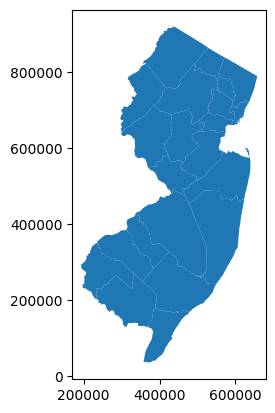

In [139]:
#make the map
njC.plot()

In [95]:
njC.head(2)

,COUNTY,COUNTY_LAB,CO,GNIS_NAME,GNIS,FIPSSTCO,FIPSCO,ACRES,SQ_MILES,POP2010,...,POP1990,POP1980,POPDEN2010,POPDEN2000,POPDEN1990,POPDEN1980,REGION,Shape_Leng,Shape_Area,geometry
0,ATLANTIC,Atlantic County,ATL,County of Atlantic,882270,34001,1,390815.404215,610.649069,274549,...,275372,204615,450,414,451,335,COASTAL,650228.153906,1.702385e+10,"POLYGON ((443056.010 311529.770, 443068.440 31..."
1,BERGEN,Bergen County,BER,County of Bergen,882271,34003,3,153490.275182,239.828555,905116,...,829592,849843,3774,3686,3459,3544,NORTHEASTERN,443326.122021,6.686010e+09,"POLYGON ((656200.963 783614.366, 656141.127 78..."


Uploading the population data


In [96]:
import pandas as pd
! wget -q -O nj-counties.zip https://github.com/nihilkottal/GIS_class/raw/main/ACSDT5YSPT2021.B01001_2023-09-12T121735.zip

zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping

##Droping the columns with the below mentioned keyword
exclude_columns_with_string = 'Annotation'
exclude_columns_with_string2 = 'Margin'

njC_population=pd.read_csv('ACSDT5YSPT2021.B01001-Data.csv',header = 1,usecols=lambda column: exclude_columns_with_string not in column and exclude_columns_with_string2 not in column)

In [97]:
njC_population.head(2)

,Geography,Geographic Area Name,Race/Ethnic Group,Population Groups,Estimate!!Total:,Estimate!!Total:!!Male:,Estimate!!Total:!!Male:!!Under 5 years,Estimate!!Total:!!Male:!!5 to 9 years,Estimate!!Total:!!Male:!!10 to 14 years,Estimate!!Total:!!Male:!!15 to 17 years,...,Estimate!!Total:!!Female:!!55 to 59 years,Estimate!!Total:!!Female:!!60 and 61 years,Estimate!!Total:!!Female:!!62 to 64 years,Estimate!!Total:!!Female:!!65 and 66 years,Estimate!!Total:!!Female:!!67 to 69 years,Estimate!!Total:!!Female:!!70 to 74 years,Estimate!!Total:!!Female:!!75 to 79 years,Estimate!!Total:!!Female:!!80 to 84 years,Estimate!!Total:!!Female:!!85 years and over,Unnamed: 200
0,0500000US34001,"Atlantic County, New Jersey",32,Asian Indian alone or in any combination,7014,3748,259,166,267,123,...,129,108,52,111,267,37,137,21,17,NaN
1,0500000US34003,"Bergen County, New Jersey",13,Asian Indian alone,35041,17407,1362,984,1203,681,...,1083,338,368,326,449,427,308,165,115,NaN


In [98]:
  list(njC_population.columns)

['Geography',
 'Geographic Area Name',
 'Race/Ethnic Group',
 'Population Groups',
 'Estimate!!Total:',
 'Estimate!!Total:!!Male:',
 'Estimate!!Total:!!Male:!!Under 5 years',
 'Estimate!!Total:!!Male:!!5 to 9 years',
 'Estimate!!Total:!!Male:!!10 to 14 years',
 'Estimate!!Total:!!Male:!!15 to 17 years',
 'Estimate!!Total:!!Male:!!18 and 19 years',
 'Estimate!!Total:!!Male:!!20 years',
 'Estimate!!Total:!!Male:!!21 years',
 'Estimate!!Total:!!Male:!!22 to 24 years',
 'Estimate!!Total:!!Male:!!25 to 29 years',
 'Estimate!!Total:!!Male:!!30 to 34 years',
 'Estimate!!Total:!!Male:!!35 to 39 years',
 'Estimate!!Total:!!Male:!!40 to 44 years',
 'Estimate!!Total:!!Male:!!45 to 49 years',
 'Estimate!!Total:!!Male:!!50 to 54 years',
 'Estimate!!Total:!!Male:!!55 to 59 years',
 'Estimate!!Total:!!Male:!!60 and 61 years',
 'Estimate!!Total:!!Male:!!62 to 64 years',
 'Estimate!!Total:!!Male:!!65 and 66 years',
 'Estimate!!Total:!!Male:!!67 to 69 years',
 'Estimate!!Total:!!Male:!!70 to 74 years',


**Cleaning the data**

In [99]:
#Creating a new column for Population groups with uniform ethnic name.
def categorize_text(text):
    if 'asian' in text.lower():
        return 'Indian'
    elif 'chinese' in text.lower():
        return 'Chinese'
    elif 'filipino' in text.lower():
        return 'Filipino'
    elif 'korean' in text.lower():
        return 'Korean'
    elif 'pakistani' in text.lower():
        return 'Pakistani'
    elif 'japanese' in text.lower():
        return 'Japanese'
    else:
        return 'Other'

# Apply the function to create a new column
njC_population['category'] = njC_population['Population Groups'].apply(categorize_text)


In [100]:
njC_population['category'].unique()

array(['Indian', 'Chinese', 'Filipino', 'Korean', 'Japanese', 'Pakistani'],
      dtype=object)

In [101]:
##Grouping people based on their age
cols = ['Estimate!!Total:!!Male:!!Under 5 years', 'Estimate!!Total:!!Male:!!5 to 9 years','Estimate!!Total:!!Male:!!10 to 14 years','Estimate!!Total:!!Male:!!15 to 17 years']
cols2 = ['Estimate!!Total:!!Male:!!18 and 19 years', 'Estimate!!Total:!!Male:!!20 years', 'Estimate!!Total:!!Male:!!21 years', 'Estimate!!Total:!!Male:!!22 to 24 years', 'Estimate!!Total:!!Male:!!25 to 29 years', 'Estimate!!Total:!!Male:!!30 to 34 years', 'Estimate!!Total:!!Male:!!35 to 39 years', 'Estimate!!Total:!!Male:!!40 to 44 years', 'Estimate!!Total:!!Male:!!45 to 49 years', 'Estimate!!Total:!!Male:!!50 to 54 years', 'Estimate!!Total:!!Male:!!55 to 59 years', 'Estimate!!Total:!!Male:!!60 and 61 years', 'Estimate!!Total:!!Male:!!62 to 64 years', 'Estimate!!Total:!!Male:!!65 and 66 years']
cols3 = ['Estimate!!Total:!!Male:!!67 to 69 years', 'Estimate!!Total:!!Male:!!70 to 74 years', 'Estimate!!Total:!!Male:!!75 to 79 years', 'Estimate!!Total:!!Male:!!80 to 84 years', 'Estimate!!Total:!!Male:!!85 years and over']
cols4 = ['Estimate!!Total:!!Female:!!Under 5 years', 'Estimate!!Total:!!Female:!!5 to 9 years', 'Estimate!!Total:!!Female:!!10 to 14 years', 'Estimate!!Total:!!Female:!!15 to 17 years']
cols5 = ['Estimate!!Total:!!Female:!!18 and 19 years', 'Estimate!!Total:!!Female:!!20 years', 'Estimate!!Total:!!Female:!!21 years', 'Estimate!!Total:!!Female:!!22 to 24 years', 'Estimate!!Total:!!Female:!!25 to 29 years', 'Estimate!!Total:!!Female:!!30 to 34 years', 'Estimate!!Total:!!Female:!!35 to 39 years', 'Estimate!!Total:!!Female:!!40 to 44 years', 'Estimate!!Total:!!Female:!!45 to 49 years', 'Estimate!!Total:!!Female:!!50 to 54 years', 'Estimate!!Total:!!Female:!!55 to 59 years', 'Estimate!!Total:!!Female:!!60 and 61 years', 'Estimate!!Total:!!Female:!!62 to 64 years', 'Estimate!!Total:!!Female:!!65 and 66 years']
cols6 = ['Estimate!!Total:!!Female:!!67 to 69 years', 'Estimate!!Total:!!Female:!!70 to 74 years', 'Estimate!!Total:!!Female:!!75 to 79 years', 'Estimate!!Total:!!Female:!!80 to 84 years', 'Estimate!!Total:!!Female:!!85 years and over']
njC_population['Male_age_17'] = njC_population[cols].sum(axis=1)
njC_population['Male_age_upto_66'] = njC_population[cols2].sum(axis=1)
njC_population['Male_age_above_66'] = njC_population[cols3].sum(axis=1)
njC_population['Female_age_17'] = njC_population[cols4].sum(axis=1)
njC_population['Female_age_upto_66'] = njC_population[cols5].sum(axis=1)
njC_population['Female_age_above_66'] = njC_population[cols6].sum(axis=1)


In [102]:
##Selecting only the required columns for our analysis
selected_columns = ['Geography', 'Geographic Area Name','Race/Ethnic Group','Population Groups','category','Estimate!!Total:','Estimate!!Total:!!Male:','Male_age_17','Male_age_upto_66','Male_age_above_66','Estimate!!Total:!!Female:','Female_age_17','Female_age_upto_66','Female_age_above_66']
njC_population = njC_population[selected_columns].copy()

In [103]:
njC_population.dtypes

Geography                    object
Geographic Area Name         object
Race/Ethnic Group             int64
Population Groups            object
category                     object
Estimate!!Total:              int64
Estimate!!Total:!!Male:       int64
Male_age_17                   int64
Male_age_upto_66              int64
Male_age_above_66             int64
Estimate!!Total:!!Female:     int64
Female_age_17                 int64
Female_age_upto_66            int64
Female_age_above_66           int64
dtype: object

In [ ]:
##Editing the Geographic area Name column so that we can merge the data with our plot
njC_population['Comma_count'] = njC_population['Geographic Area Name'].str.count(',')
njC_population1 = njC_population[njC_population['Comma_count'] == 1]
njC_population1[['County', 'State']] = njC_population1['Geographic Area Name'].str.split(',', expand=True)

njC_population2 = njC_population[njC_population['Comma_count'] == 2]
njC_population2[['Town','County', 'State']] = njC_population2['Geographic Area Name'].str.split(',', expand=True)
column_name_to_remove = 'Town'
njC_population2 = njC_population2.drop(columns=column_name_to_remove)

njC_population = pd.concat([njC_population1, njC_population2])


len(njC_population)

In [72]:
  list(njC_population.columns)

['Geography',
 'Geographic Area Name',
 'Race/Ethnic Group',
 'Population Groups',
 'category',
 'Estimate!!Total:',
 'Estimate!!Total:!!Male:',
 'Male_age_17',
 'Male_age_upto_66',
 'Male_age_above_66',
 'Estimate!!Total:!!Female:',
 'Female_age_17',
 'Female_age_upto_66',
 'Female_age_above_66',
 'Comma_count',
 'County',
 'State']

In [105]:
##Getting rid of leading and trailing whitespace

njC_population['County'] = njC_population['County'].str.strip()


##Aggregate the data to so that many to one relationship is avoided

grouped = njC_population.groupby(['category','County']).agg({'Estimate!!Total:': 'sum', 'Estimate!!Total:!!Male:': 'sum','Male_age_17': 'sum','Male_age_upto_66': 'sum','Estimate!!Total:!!Female:': 'sum','Female_age_17': 'sum','Female_age_upto_66': 'sum','Female_age_above_66': 'sum'}).reset_index()
grouped.head(2)

,category,County,Estimate!!Total:,Estimate!!Total:!!Male:,Male_age_17,Male_age_upto_66,Estimate!!Total:!!Female:,Female_age_17,Female_age_upto_66,Female_age_above_66
0,Chinese,Bergen County,94724,45632,11243,28748,49092,8866,33058,7168
1,Chinese,Camden County,14698,6895,2084,4135,7803,2362,4533,908


In [108]:
####Merging Datasets

grouped.rename(columns={'County': 'COUNTY_LAB'}, inplace=True)
merged_data = pd.merge(njC, grouped, on='COUNTY_LAB',how='outer',indicator=True)
len(merged_data)
merged_data.dtypes

41

COUNTY                         object
COUNTY_LAB                     object
CO                             object
GNIS_NAME                      object
GNIS                           object
FIPSSTCO                       object
FIPSCO                         object
ACRES                         float64
SQ_MILES                      float64
POP2010                         int64
POP2000                         int64
POP1990                         int64
POP1980                         int64
POPDEN2010                      int64
POPDEN2000                      int64
POPDEN1990                      int64
POPDEN1980                      int64
REGION                         object
Shape_Leng                    float64
Shape_Area                    float64
geometry                     geometry
category                       object
Estimate!!Total:              float64
Estimate!!Total:!!Male:       float64
Male_age_17                   float64
Male_age_upto_66              float64
Estimate!!To

In [147]:
indian = merged_data[merged_data['category'] == 'Indian']

<Axes: >

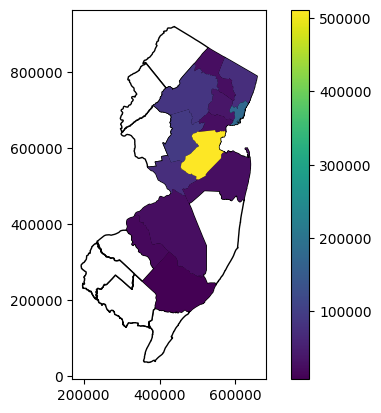

In [151]:
base = njC.plot(color='white', edgecolor='black')
indian.plot(ax=base, column="Estimate!!Total:", figsize=(10,12),legend = True)


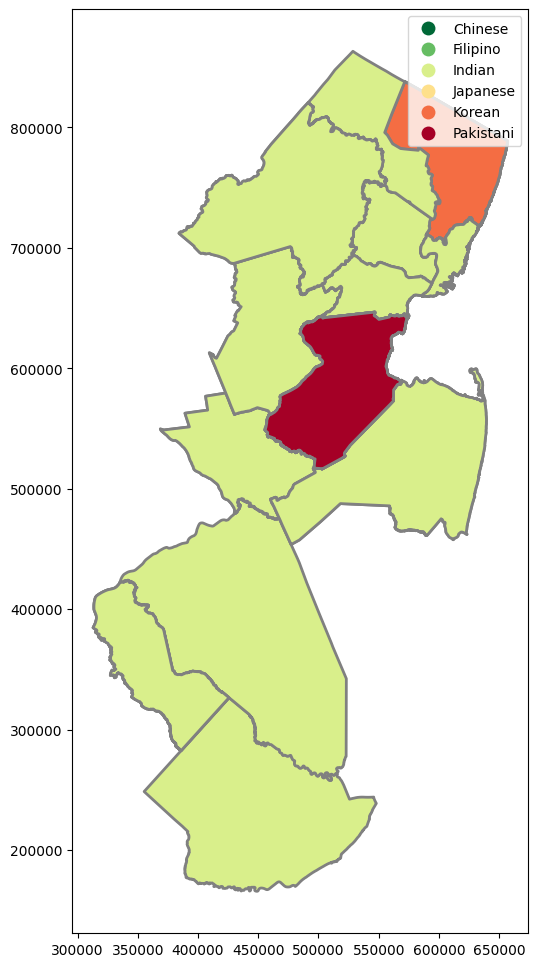

In [131]:

 base = merged_data.plot(figsize=(10,12),categorical = True,column='category',legend=True,cmap='RdYlGn_r',
           edgecolor='grey',k=6,linewidth=2,legend_kwds= {"fmt": "{:,.0f}"})


In [87]:
from google.colab import files
grouped.to_csv('grouped.csv', index=False)
# Download the file to your local machine
files.download('grouped.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>